# Part1. 從資料看電影史

電影工業越來越發達，題材也越來越多元。我想要透過這份資料集，純粹由資料的觀點出發，看看隨著**時間**演進，電影的發展出現了哪些變化。<br>
如電影的產出數量、電影的元素、觀眾的喜愛等等。

* * *
## 基本前處理：取得時間資訊
接下來的觀察會大量地使用到**時間**這項變數，但在原始資料集內並沒有電影的時間相關資訊，僅在*movies.csv*中的*title*中名稱後面加上了可能是上映年份的資料，我便取這個值作為電影的年份。

In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
plt.rcParams['figure.figsize'] = [20, 16]

In [3]:
movies_filepath = "./data/ml-20m/movies.csv"

In [4]:
df_movies = pd.read_csv(movies_filepath)

原始資料如下

In [5]:
df_movies[:3]

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance


In [6]:
def extract_year(text):
    """ Given a string, extract year from it.
        Args:
            text: string
        Returns:
            year: float
    """
    pattern = re.compile(r'\((\d{4})\)')
    result = pattern.search(text)
    if result:
        return result.group(1)
    else:
        return None


In [7]:
df_movies['year'] = df_movies['title'].map(extract_year)

In [8]:
num_movie_before_cleaned = len(df_movies)
df_movies = df_movies[pd.notnull(df_movies['year'])]
df_movies['year'] = df_movies['year'].astype(np.int32)
num_movie_cleaned = len(df_movies)

print("{} / {} 部電影並沒有欄位資料".format(num_movie_before_cleaned-num_movie_cleaned, num_movie_before_cleaned))

22 / 27278 部電影並沒有欄位資料


調整後的結果如下

In [9]:
df_movies[:3]

,movieId,title,genres,year
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men (1995),Comedy|Romance,1995


* * *

## 電影產業的變化

### 歷年的電影**數量**與**類型**
有了時間資訊以後，就先來觀察一下資料的基本樣子吧，首先就先簡單看看歷年來電影的數量發展變化

In [10]:
count_series = df_movies['year'].value_counts()
count_series = count_series.reset_index()
count_series.columns = ['year', 'count']

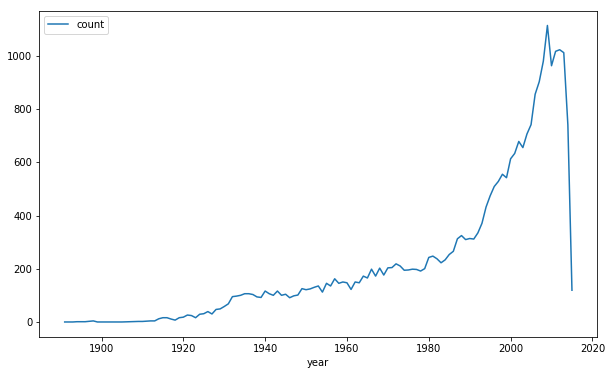

In [11]:
count_series.set_index('year').sort_index().plot(figsize=(10, 6))

#### 數量變化上的觀察
1. 從趨勢來看電影的發展大概從 1930 年代開始，電影數量開始慢慢發展。查了一下，**有聲電影**以及**彩色電影**大約在這時期引進市場。猜想這兩者的出現可能對電影市場的發展有很大的助益。
2. 1990 年代電影數量開始大幅度增加，這部份可能的原因尚待釐清。

另外來看看各類型電影的統計
** 註 ** 一部電影可能包含有多種類型，如「愛情喜劇」

In [12]:
from collections import Counter, defaultdict

In [13]:
genres, counts = zip(*Counter([g for genres in df_movies['genres'] for g in genres.split('|')]).items())

([<matplotlib.axis.XTick at 0x109415400>,
 <a list of 20 Text xticklabel objects>)

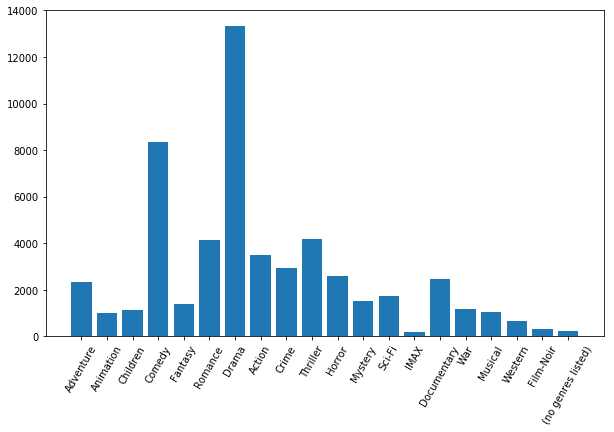

In [14]:
x_index = np.arange(len(genres))
plt.figure(figsize=(10, 6))
plt.bar(x_index, counts)
plt.xticks(x_index, genres, rotation=60)

#### 影片類型上的觀察
1. 出乎我意料之外，我原先想像電影類型應該會以動作片、冒險片居多，但圖表呈現的是劇情以及喜劇類型的電影數量大幅領先其他類型，不知道這樣的結果是否跟預算以及技術有關。
2. 這份圖表是所有年份的電影統計，接下來要更細部地來看歷年來的變化。

### 在不同的時代，流行的電影類型是否不同
看到上面的結果讓人不禁好奇：會不會在不同的時代背景下，電影的類型會有所不同。<br>

In [15]:
# 各年份內的不同元素的電影數量統計
year_dict = {}
for index, row in df_movies.iterrows():
    year = row['year']
    genres = row['genres'].split('|')
    
    if np.isnan(year):
        continue 
        
    if year not in year_dict:
        year_dict[year] = defaultdict(int)

    for g in genres:
        year_dict[year][g] += 1

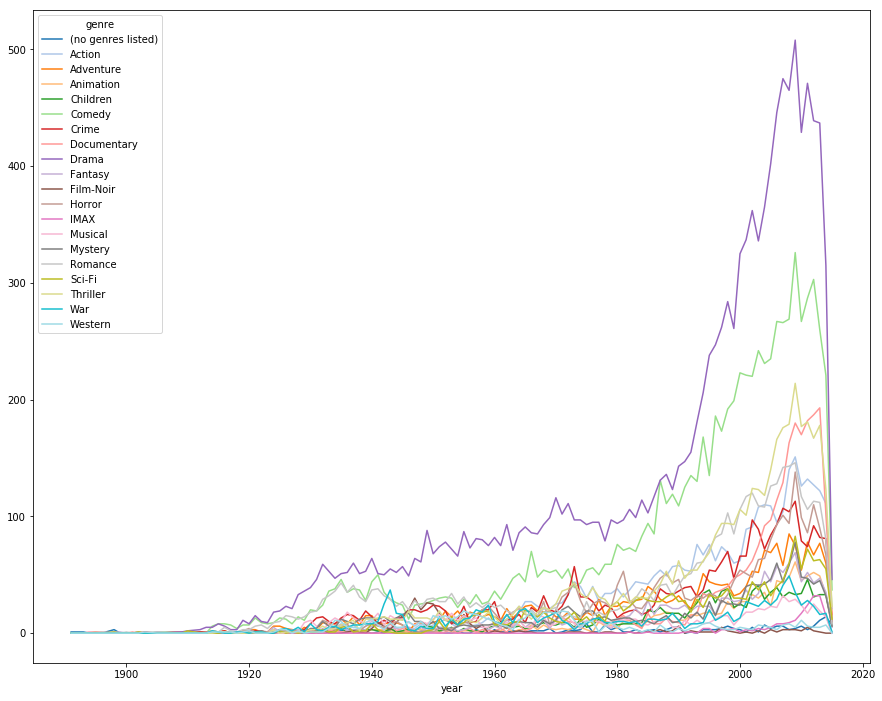

In [16]:
df_genres = pd.DataFrame(year_dict).fillna(0)
df_genres = df_genres.stack().reset_index()
df_genres.columns = ['genre', 'year', 'count']
df_genres = df_genres.pivot(index='year', columns='genre', values='count')
df_genres.plot(colormap='tab20', figsize=(15,12))

#### 時間與電影類型的觀察
1. 從圖表上可以劇情、喜劇類型電影稱霸幾乎是從電影開始發展之初就有的狀況，與電影業剛開始相比，過去會有較多的浪漫類型電影，但現在似乎有被驚悚片取代的趨勢。
2. 1940 年代中期，**戰爭**元素的電影一度大幅成長，超越了原先的浪漫與喜劇類型，甚至達到第二名。而這時間又剛好是*第二次世界大戰*發生期間(1939-1945)。
3. 1970 年代的**犯罪**元素電影站上排行榜第二名，查了一下網路可以看到一些關於該年代的犯罪討論
    - [The 1970s - a decade notorious for crime](https://www.sfgate.com/crime/article/The-1970s-a-decade-notorious-for-crime-4116915.php)
    - [Crimes and cults of the '70s](https://edition.cnn.com/2015/07/08/us/gallery/seventies-cults-and-crimes/index.html)
    
從上面的結果來看，*時代背景的確可能會影響電影的類型*。

上面的結果若是改成百分比，看看每一年度的**影片類型比例**，或許能夠看到不一樣的觀點。

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117]), <a list of 118 Text xticklabel objects>)

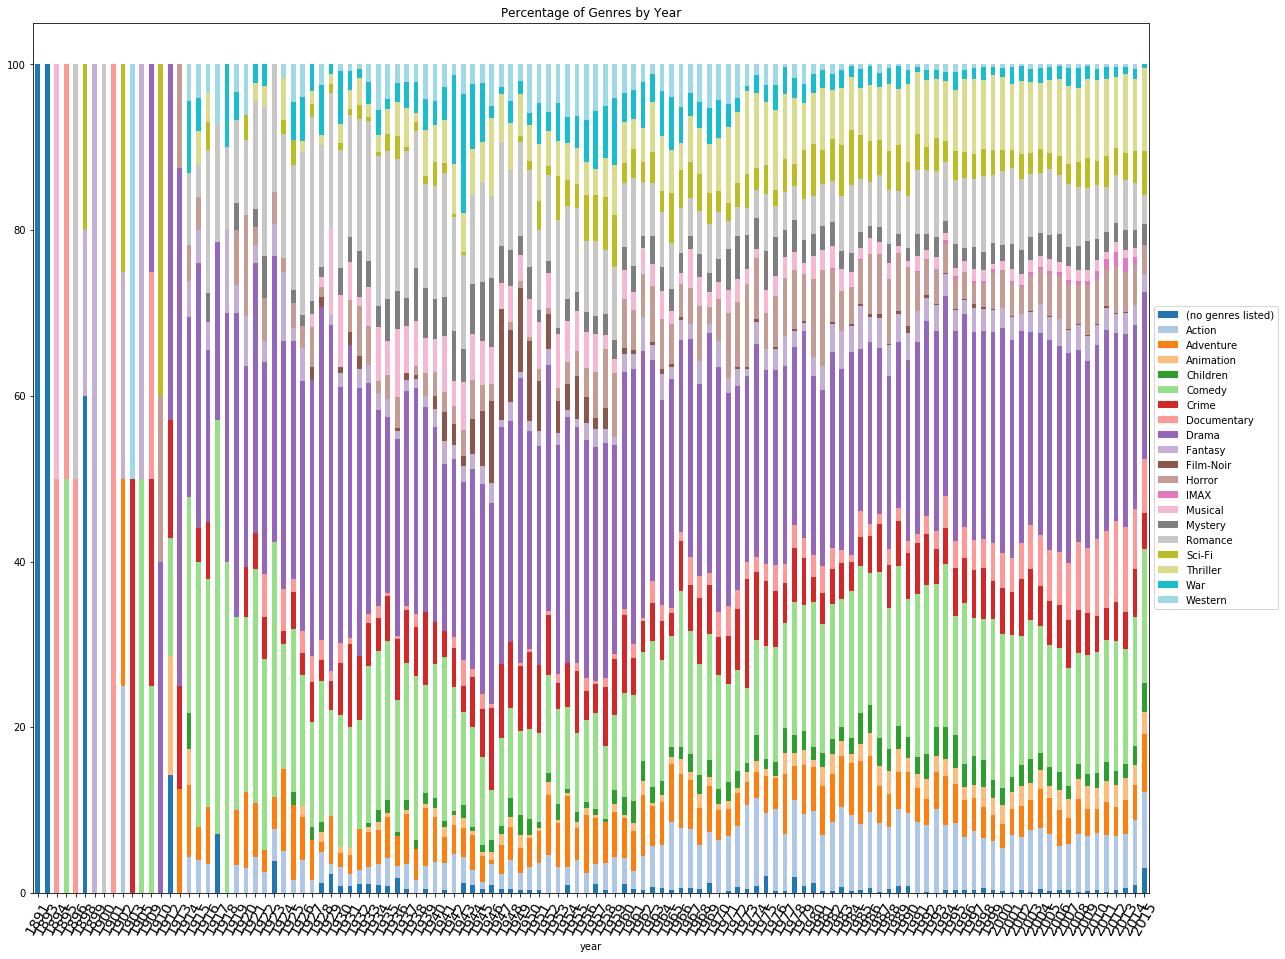

In [17]:
df_percent = df_genres.div(df_genres.sum(1)/100, 0)

fig = plt.figure()
plt.title('Percentage of Genres by Year', color='black')
df_percent.plot(kind='bar', stacked=True, colormap='tab20', ax=fig.gca())
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.xticks(fontsize=14, rotation=60)

#### 各年代電影類型百分比的觀察
1. 大概在1910年代以前，電影的類型相對簡單。
2. 之後「劇情」以及「喜劇」類型的電影就穩定地佔有一席之地；近年來「驚悚片」以及「紀錄片」的比例逐漸提升；「西部片」、「戰爭片」、「音樂劇」、「浪漫類型」的電影比例不若以往。
3. 另外值得一提的是即使在1930年代開始出現彩色電影，但「黑白」電影仍在 1940 ~ 1960 年間佔有一席之地。

### 電影類型的組成，是否呈現越來越豐富的趨勢？
現在不少的電影介紹可以看到強調「親情」「愛情」「冒險」等多項元素的融合，所以不禁讓人好奇類型的組成是否越來越多樣。

In [18]:
df_movies['genre_count'] = df_movies['genres'].apply(lambda x: len(x.split('|')))

In [19]:
df_cleaned = df_movies[pd.notnull(df_movies['year'])]

In [20]:
bins = [x for x in range(1890, 2030, 10)]
df_movies['bin_year'] = pd.cut(df_movies['year'].tolist(), bins, right=False)

In [21]:
bin_years = []
level = df_movies['bin_year'].unique()
for x in level:
    bin_years.append(df_movies.loc[df_movies['bin_year'] == x, 'genre_count'])

/Users/jlin/.local/share/virtualenvs/ml--jIXfkQE/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


{'boxes': [<matplotlib.patches.PathPatch at 0x10ab267f0>,
 'caps': [<matplotlib.lines.Line2D at 0x10ab79f60>,
 'fliers': [<matplotlib.lines.Line2D at 0x10ac27a20>,
 'means': [<matplotlib.lines.Line2D at 0x10abffa20>,
 'medians': [<matplotlib.lines.Line2D at 0x10abd66a0>,
 'whiskers': [<matplotlib.lines.Line2D at 0x10ab3cf60>,
  <matplotlib.lines.Line2D at 0x10ba1cda0>]}

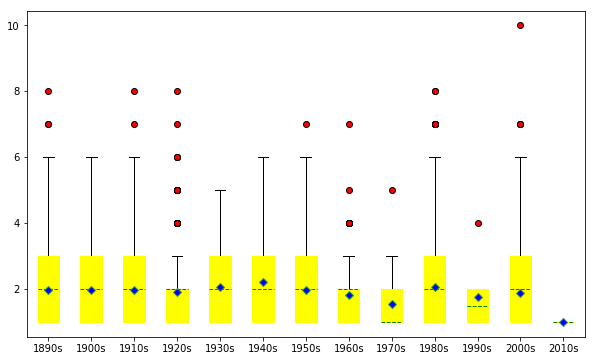

In [22]:
# ref: https://www.kesci.com/apps/home/project/59f6ec6dc5f3f511952c228e
plt.figure(figsize=(10, 6))
plt.boxplot(x=bin_years,
            patch_artist=True,
            labels = [str(x)+'s' for x in range(1890, 2020, 10)],
            showmeans=True, 
            boxprops = {'color':'yellow','facecolor':'yellow'}, 
            flierprops = {'marker':'o','markerfacecolor':'red','color':'black'},
            meanprops = {'marker':'D','markerfacecolor':'blue'},
            medianprops = {'linestyle':'--','color':'green'})

#### 類型組成變化的觀察
1. 歷年來電影的類型組成大約都落在兩個左右(平均值為藍色方點，中位數為綠色虛線)。<br>
較特殊的狀況大概在60, 70 還有 90年代，這些年代的電影平均值、中位數以及四分位數都較低。需要看看有無可能是資料蒐集上有問題。

從上圖來看，歷年來電影類型的豐富性變化不大，但這是針對數量上而言。<br>我認為有可能**類型的變化會反應在組合**上，如雖然平均而言有兩種類型，但可能一個是「愛情」、「喜劇」的組合，另外一個則是「動作」、「喜劇」。<br>
電影類型組合的變化這個問題或許能夠用關聯式演算法如 *Apriori*, *FP-Growth* 等方式來觀察。

***
# Part.2 資料的分群

## 使用者電影偏好分析
第二部分希望透過這份資料集找出有共同嗜好的使用者。<br>
我的目標是利用使用者的電影評分紀錄建立一個能夠代表使用者的向量，並用這向量來進行分群。<br>

### 前處理
首先先觀察一下檔案內容

In [23]:
rating_filepath = "./data/ml-20m/ratings.csv"

In [24]:
df_rating = pd.read_csv(rating_filepath)

In [25]:
df_rating[:3]

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819


因為 movieId 並沒有一定的規則，所以之後以自訂的 movie_index 來取代 movieId 。

In [26]:
movieId_to_index = {}
for _id in df_rating['movieId'].unique():
    if _id not in movieId_to_index:
        movieId_to_index[_id] = len(movieId_to_index)

In [27]:
df_rating['movie_index'] = df_rating['movieId'].map(lambda x: movieId_to_index[x])

In [28]:
df_rating[:3]

,userId,movieId,rating,timestamp,movie_index
0,1,2,3.5,1112486027,0
1,1,29,3.5,1112484676,1
2,1,32,3.5,1112484819,2


### 建立使用者向量
接下來的目標是建立一個 使用者人數*電影數量 的矩陣，矩陣內的值即為使用者對某電影的評分，0則代表使用者未評分該電影（缺點：0 這個分數變成兩個意思，「0分」或是「未評分」）<br>
先看看資料內有多少零分的紀錄，評估0對我們的矩陣表示會有什麼樣的影響。

In [29]:
sum(df_rating['rating'] == 0)

0

竟然沒有人給過0分的評論！這樣子的話對我們的矩陣表示的影響應該會小一點。

In [30]:
num_movie = len(movieId_to_index)
num_user = len(df_rating['userId'].unique())
print("Num of users: {}, Num of movies: {}".format(num_user, num_movie))

Num of users: 138493, Num of movies: 26744


In [31]:
# maybe a better method to construct this matrix
user_matrix = np.zeros((num_user, num_movie))

# takes little time to process.
for index, row in enumerate(df_rating.loc[:, ['userId', 'movie_index', 'rating']].values):
    user_id = int(row[0])
    movie_index = int(row[1])
    rating = float(row[2])
    user_matrix[user_id-1][movie_index] = rating

### 分群
特徵矩陣建立後，便可以利用它來為使用者分群，<br>
步驟會是先建立一個pipe line將矩陣作奇異值分解SVD後正規化，再利用正規化後的矩陣利用KMeans作分群。<br>
這裡需要會測試不同的群數時的分群效果，但因為資料集內沒有truth的資訊，所以我會用輪廓係數(silhouette coefficient)來看看分群的效果如何。

註：因為矩陣很大，分群以及繪圖會需要較多時間，我先設定取一千名使用者來操作

In [32]:
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import silhouette_score, silhouette_samples
from scipy import sparse

In [33]:
# takes little time to process
max_user = 1000
X = sparse.csr_matrix(user_matrix[:max_user])

In [34]:
X

<1000x26744 sparse matrix of type '<class 'numpy.float64'>'
	with 150629 stored elements in Compressed Sparse Row format>

In [35]:
# ref: https://stackoverflow.com/questions/42394846/why-use-lsa-before-k-means-when-doing-text-clustering
svd = TruncatedSVD()
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)
_X = lsa.fit_transform(X)

In [36]:
models = [(k, KMeans(n_clusters=k)) for k in range(6, 21, 2)]

In [37]:
import matplotlib.cm as cm
from matplotlib.pyplot import spectral

Number of clusters = 6, silhouette_score: 0.7236944527473306


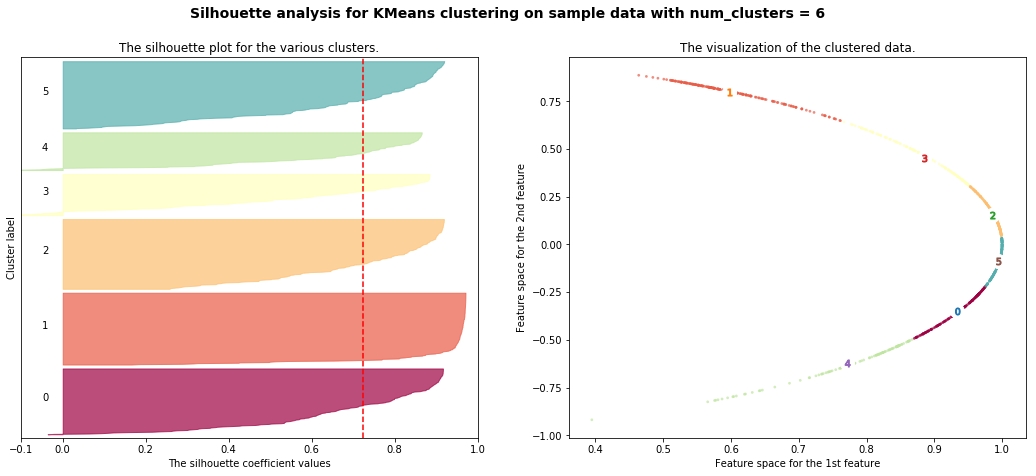

Number of clusters = 8, silhouette_score: 0.7474813758906569


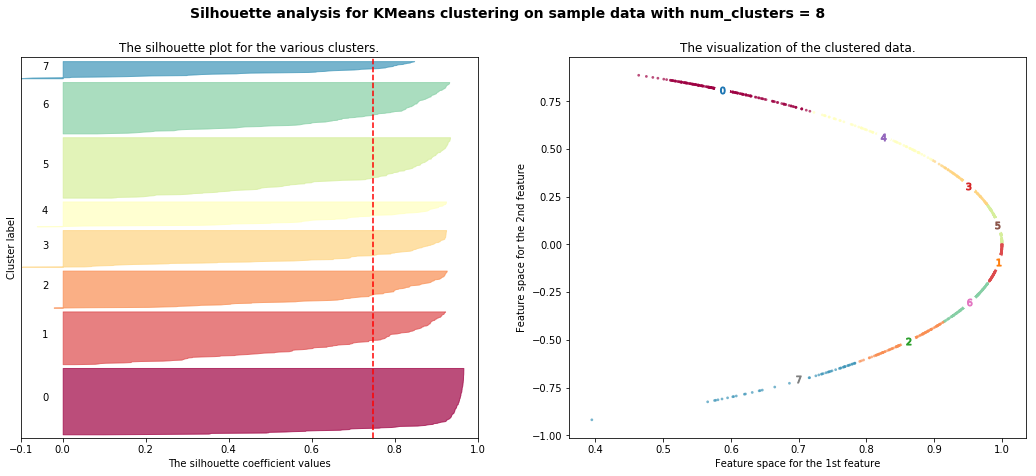

Number of clusters = 10, silhouette_score: 0.7308822255620209


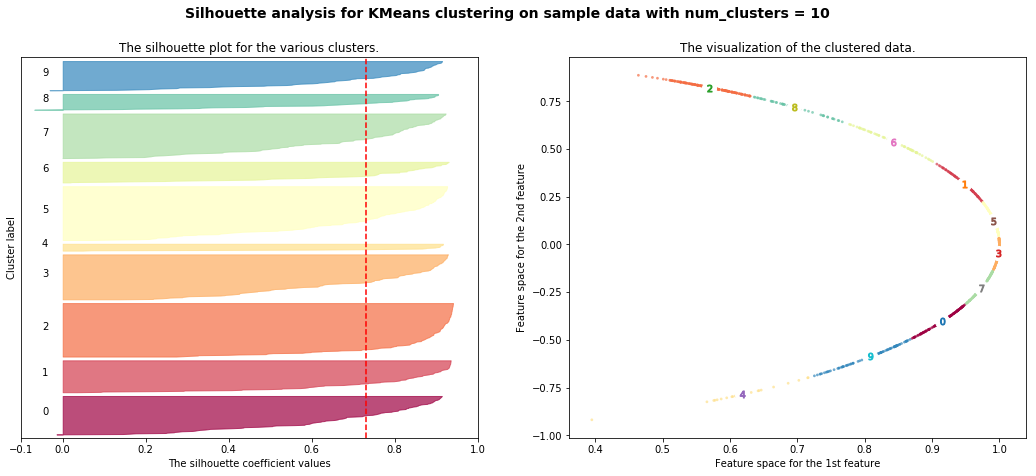

Number of clusters = 12, silhouette_score: 0.7232968941347098


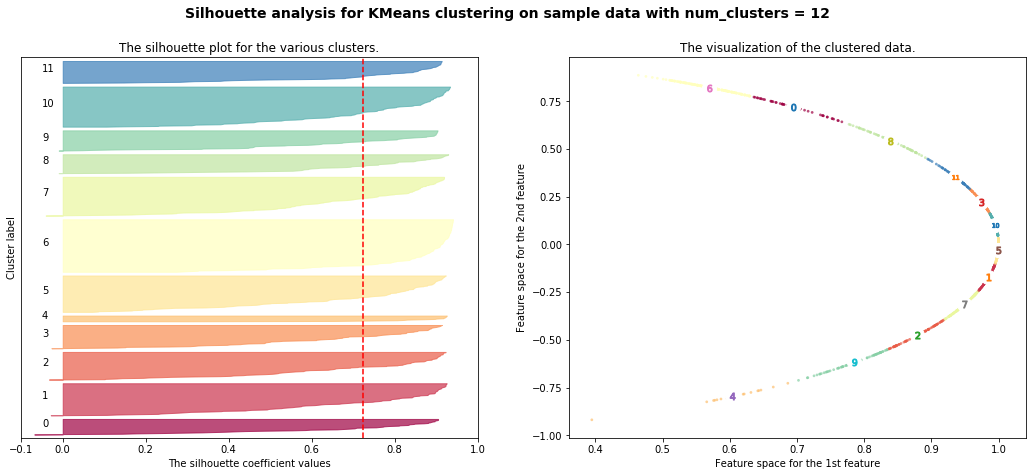

Number of clusters = 14, silhouette_score: 0.7120518722355581


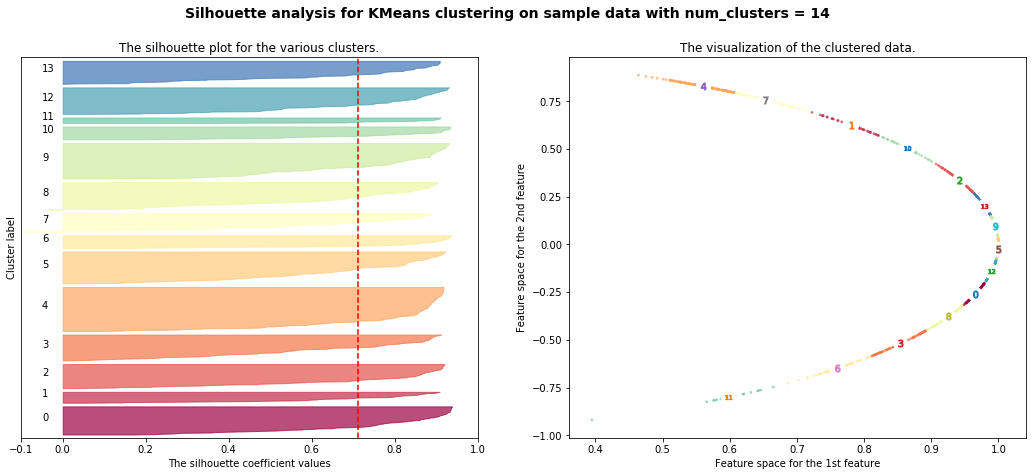

Number of clusters = 16, silhouette_score: 0.7187519486247471


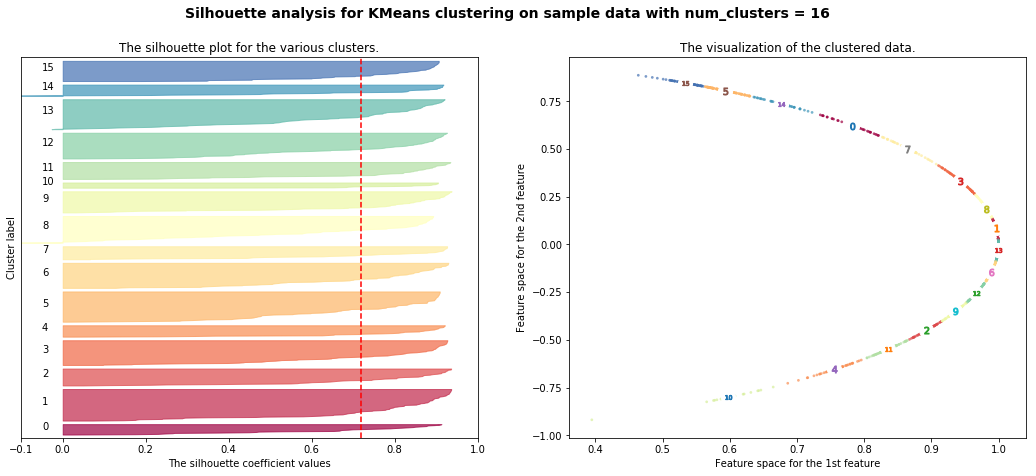

Number of clusters = 18, silhouette_score: 0.714931957582642


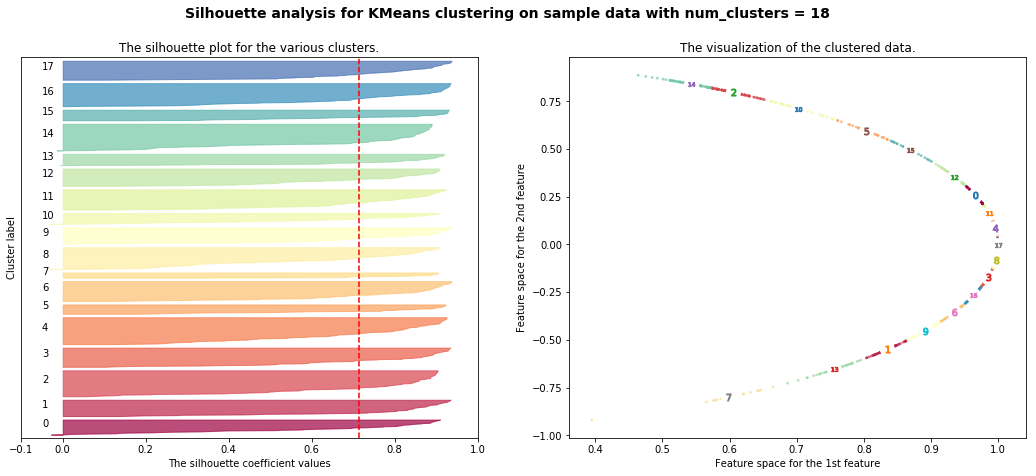

Number of clusters = 20, silhouette_score: 0.7039457803630219


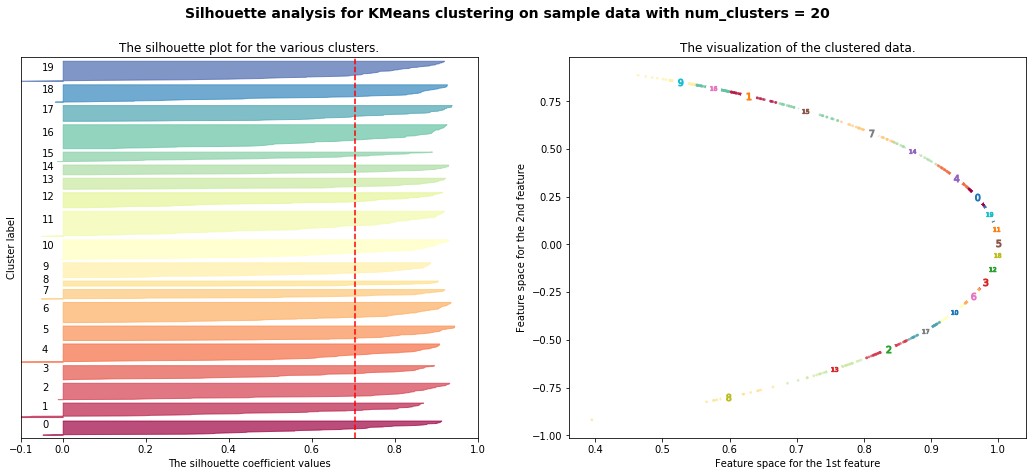

In [38]:
# ref: http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

for num_clusters, model in models:  
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(_X) + (num_clusters + 1) * 10])
    
    model.fit(_X)
    silhouette_avg = silhouette_score(_X, model.labels_, metric='cosine')
    print("Number of clusters = {}, silhouette_score: {}".format(num_clusters, silhouette_avg))
    sample_silhouette_values = silhouette_samples(_X, model.labels_, metric='cosine')
    
    y_lower = 10
    for i in range(num_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[model.labels_ == i]
        ith_cluster_silhouette_values.sort()
        
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        color = cm.Spectral(float(i) / num_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10  # 10 for the 0 samples
        
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    
    # silouette score 的平均值（圖中的垂直紅色虛線）
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    
    # clustering 結果（右圖）
    colors = cm.Spectral(model.labels_.astype(float) / num_clusters)
    ax2.scatter(_X[:, 0], _X[:, 1], marker='.', 
                s=30, lw=0, alpha=0.7, c=colors)
    # 標出群中心
    centers = model.cluster_centers_    
    ax2.scatter(centers[:, 0], centers[:, 1],
                marker='o', c="white", alpha=1, s=200)
    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")
    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with num_clusters = %d" % num_clusters),
                 fontsize=14, fontweight='bold')
    plt.show()

#### 使用者分群的觀察
1. 從輪廓係數來看，雖然在各個K值時的平均值都相當高，但仔細看圖表，會發現不少群的輪廓係數值變動較大（尖刀的形狀）。<br>
這可能表示雖然群與群之間雖然距離有拉開，但同群之間有些點並不容易與其他群分別。所以目前這樣的分群效果並不能說很好，但群中心的部分應該還是有參考價值的。下面嘗試看看驗證我的推論<br>

In [39]:
from sklearn.metrics.pairwise import cosine_similarity

In [40]:
model = KMeans(n_clusters=6)
labels = model.fit_predict(_X)
similarities = cosine_similarity(_X)

In [41]:
print('前十位使用者的分群結果:',labels[:10])
print('\n使用者的相似度矩陣:\n {}\n'.format(similarities))

前十位使用者的分群結果: [1 2 2 0 0 0 2 0 5 2]

使用者的相似度矩陣:
 [[ 1.          0.90164006  0.92720116 ...  0.86446198  0.54685587
   0.81009643]
 [ 0.90164006  1.          0.99799575 ...  0.9968441   0.85515704
   0.47684958]
 [ 0.92720116  0.99799575  1.         ...  0.98982268  0.8206402
   0.53151688]
 ...
 [ 0.86446198  0.9968441   0.98982268 ...  1.          0.8936085
   0.40556729]
 [ 0.54685587  0.85515704  0.8206402  ...  0.8936085   1.
  -0.04785727]
 [ 0.81009643  0.47684958  0.53151688 ...  0.40556729 -0.04785727
   1.        ]]



可以看到第二個使用者與第三個使用者在屬於同一群，相似度高達 99%，而第一個使用者與第二個使用者雖然分屬不同群，但相似度依然高達 90%。<br>
這樣的狀況應該支持了我對前面觀察分群結果的推測。

## 各群使用者的特徵
接下來我想要了解不同群的使用者在電影類型選擇上的差異。<br>
我會以一樣1000名使用者的資料並利用KMeans並設定K=6去分群，找出這六群的中心點最近的使用者作為代表。分析這六位使用者觀看的電影類型有什麼不同。

In [43]:
cluster_result = {i: np.where(model.labels_ == i)[0] for i in range(model.n_clusters)}

In [44]:
from sklearn.metrics import pairwise_distances_argmin_min

In [45]:
center_users, _ = pairwise_distances_argmin_min(model.cluster_centers_, _X)

In [46]:
user_movie_dict = defaultdict(list)
for user_id in center_users:
    watched_list = df_rating[df_rating['userId']==user_id]['movieId'].tolist()
    for movie_id in watched_list:
        genres = df_movies.at[df_movies['movieId'].eq(movie_id).idxmax(), 'genres'].split('|')
        user_movie_dict[user_id].extend(genres)
    user_movie_dict[user_id] = Counter(user_movie_dict[user_id])

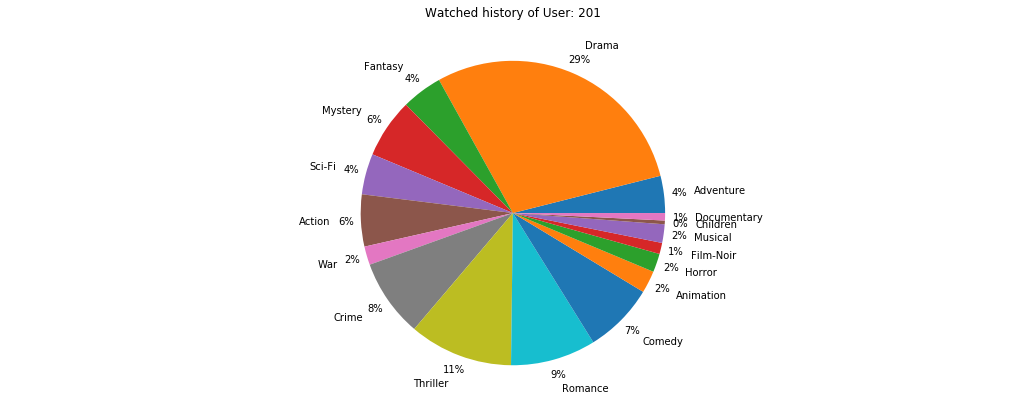

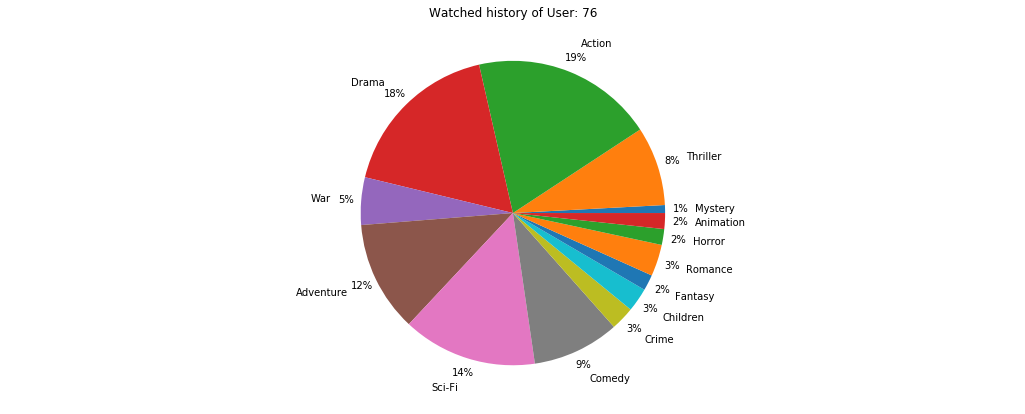

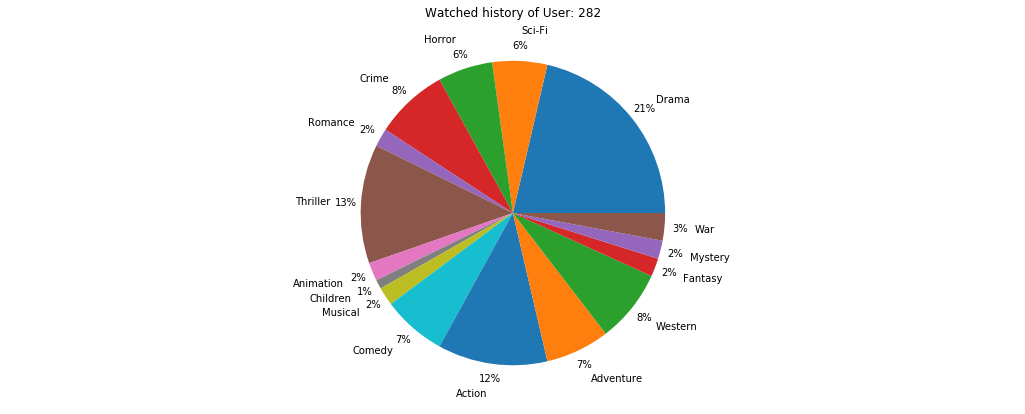

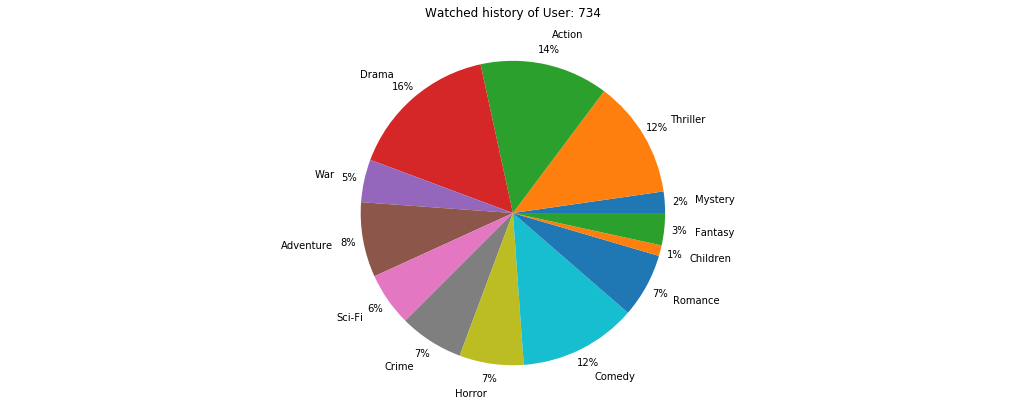

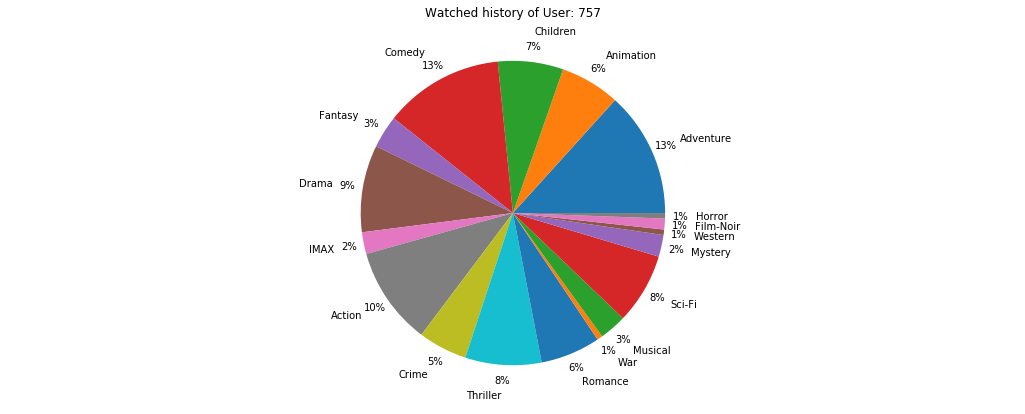

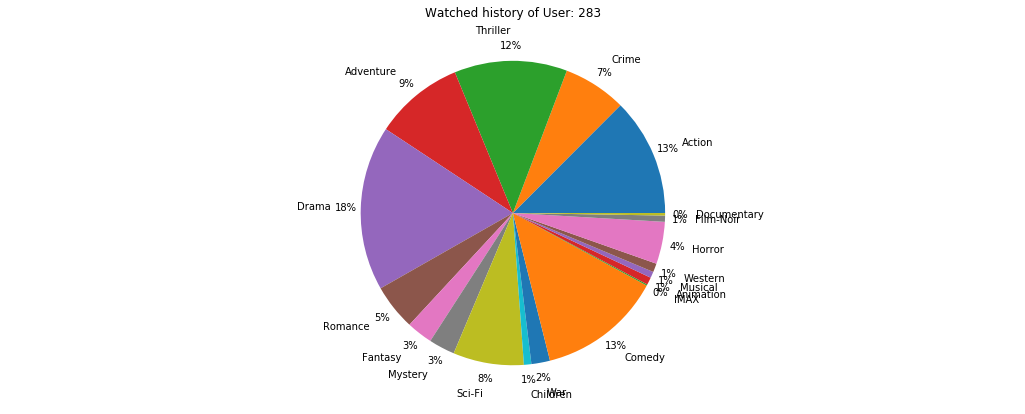

In [49]:
for user_id, genre_count in user_movie_dict.items():
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(18, 7)
    plt.axis('equal')
    plt.title('Watched history of User: {}'.format(user_id))
    ax1.pie([float(v) for v in genre_count.values()], labels=[k for k in genre_count.keys()], autopct='%1.0f%%', pctdistance=1.1, labeldistance=1.2)

#### 六種使用者的觀察
1. 第一位特徵使用者前三名比例依序： 「戲劇」，「喜劇」，「動作」<br>
第二位特徵使用者前三名比例依序： 「戲劇」，「驚悚」，「浪漫」<br>
第三位特徵使用者前三名比例依序： 「戲劇」，「喜劇」，「動作」<br>
第四位特徵使用者前三名比例依序： 「喜劇」，「戲劇」，「動作」<br>
第五位特徵使用者前三名比例依序： 「喜劇」，「冒險」，「驚悚」<br>
第六位特徵使用者前三名比例依序： 「恐怖」，「驚悚」，「戲劇」

2. 第一位與第三位特徵使用者的排名依序雖然相同，但第三位使用者似乎對其他類型的電影的接受度更高。